## Library

In [44]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Load Data

In [45]:
def load(folders, max_images_per_class=100):
    images = []
    labels = []
    count = {}
    
    for folder_path in folders:
        folder_name = os.path.basename(folder_path)
        count[folder_name] = 0
        
        for filename in tqdm(os.listdir(folder_path)):
            if count[folder_name] >= max_images_per_class:
                break
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (150, 150))
                images.append(img)
                labels.append(folder_name)
                count[folder_name] += 1
    
    return images, labels, count 

folders = ['monarch', 'pipevine_swallow', 'straited_queen']
images, labels, count = load(folders)

100%|██████████| 100/100 [00:00<00:00, 104.45it/s]


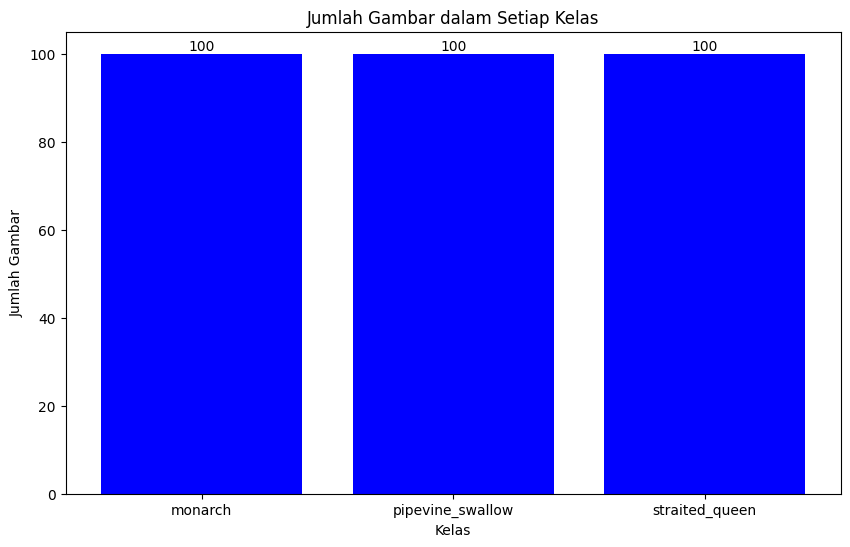

In [46]:
plt.figure(figsize=(10, 6))
bars = plt.bar(count.keys(), count.values(), color='blue')
plt.title('Jumlah Gambar dalam Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height),
             ha='center', va='bottom', fontsize=10)
plt.show()

## GLCM

In [47]:
dict_labels = {
    'monarch': 0,
    'pipevine_swallow': 1,
    'straited_queen': 2,
}

In [48]:
def contrast(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i, j] * pow(i - j, 2)
    return hasil

def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i, j] * abs(i - j)
    return hasil

def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (data[i, j] / (1 + pow(i - j, 2)))
    return hasil

def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil

def correlation(data):
    mean_x = 0
    mean_y = 0
    std_x = 0
    std_y = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean_x += i * data[i][j]
            mean_y += j * data[i][j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std_x += (i - mean_x) ** 2 * data[i][j]
            std_y += (j - mean_y) ** 2 * data[i][j]
    std_x = math.sqrt(std_x)
    std_y = math.sqrt(std_y)
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i - mean_x) * (j - mean_y) * data[i][j]
    hasil /= std_x * std_y
    return hasil

def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy

def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [49]:
def extract_glcm_features(images, labels, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    angle_labels = ['0', '45', '90', '135']
    df_data = pd.DataFrame()
    for i, image in enumerate(tqdm(images)):
        image = image.astype(int)
        glcm = graycomatrix(image, distances, angles, levels, symmetric, normed)
        for feature in features:
            for angle, angle_label in zip(angles, angle_labels):
                glcm_matrix = glcm[:, :, 0, int(angle * 4 / np.pi)]
                if feature == 'contrast':
                    feat_a = contrast(glcm_matrix)
                elif feature == 'dissimilarity':
                    feat_a = dissimilarity(glcm_matrix)
                elif feature == 'homogeneity':
                    feat_a = homogeneity(glcm_matrix)
                elif feature == 'energy':
                    feat_a = energy(glcm_matrix)
                elif feature == 'correlation':
                    feat_a = correlation(glcm_matrix)
                df_data.loc[i, f'{feature}_{angle_label}'] = feat_a
        for angle, angle_label in zip(angles, angle_labels):
            glcm_matrix = glcm[:, :, 0, int(angle * 4 / np.pi)]
            asm_value = asm(glcm_matrix)
            entropy_value = entropy(glcm_matrix)
            df_data.loc[i, f'asm_{angle_label}'] = asm_value
            df_data.loc[i, f'entropy_{angle_label}'] = entropy_value
        df_data.loc[i, 'label'] = dict_labels[labels[i]]
    return df_data

## Seleksi Fitur

In [50]:
df_glcm = extract_glcm_features(images, labels)

correlations = df_glcm.corr()['label'].abs().sort_values(ascending=False)
top_features = correlations.index[1:26] 

100%|██████████| 300/300 [07:46<00:00,  1.56s/it]


In [51]:
x, y = df_glcm[top_features], df_glcm['label']

In [52]:
pca = PCA(n_components=25)
x_pca = pca.fit_transform(x)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## KNN, SVM, RFC

In [54]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)
knn_pred = knn_model.predict(x_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

svm_model = SVC()
svm_model.fit(x_train, y_train)
svm_pred = svm_model.predict(x_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

In [55]:
model_dict = {
    'KNN': knn_model,
    'SVM': svm_model,
    'RF': rf_model
}

df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())

In [56]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred, average='weighted')

In [57]:
print(df_eval)

     Accuracy Precision    Recall  F1 Score
KNN  0.516667  0.559136  0.516667  0.520923
SVM  0.633333  0.643107  0.633333   0.63046
RF   0.583333   0.58746  0.583333  0.584753


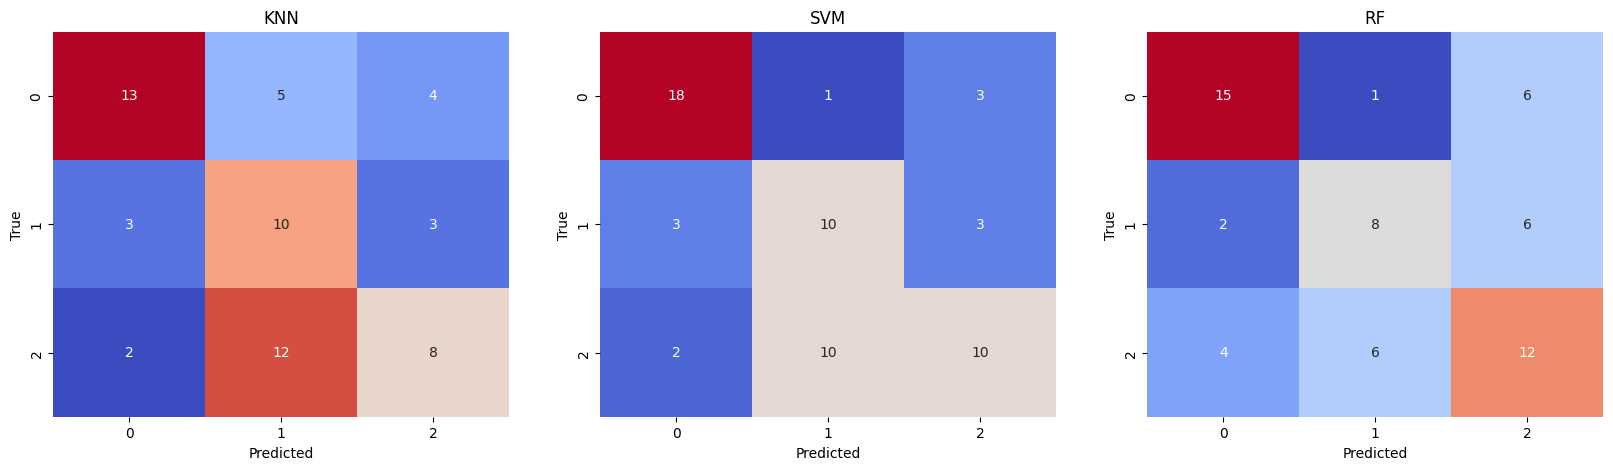

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, model_name in enumerate(model_dict.keys()):
    y_pred = model_dict[model_name].predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(model_name)
plt.show()